In [222]:
import cv2
import fitz
import matplotlib.pyplot as plt
import numpy as np
import scipy
from math import sin, cos
from pyfishsensedev.library.array_read_write import read_camera_calibration
from pyfishsensedev.image.image_processors.raw_processor import RawProcessor
from pyfishsensedev.image.image_rectifier import ImageRectifier
from pathlib import Path

In [223]:
def uint16_2_double(img: np.ndarray) -> np.ndarray:
    return img.astype(np.float64) / 65535

def uint16_2_uint8(img: np.ndarray) -> np.ndarray:
    return (uint16_2_double(img) * 255).astype(np.uint8)

In [224]:
lens_calibration_path = Path("./data/lens-calibration.pkg")

slate_path = "./data/SMILE Calibration Slate.pdf"
img_path = Path("/home/chris/data/fishsense/H slate dive 3/P8030189.ORF").absolute()

In [225]:
calibration_matrix, distortion_coeffs = read_camera_calibration(
    lens_calibration_path.as_posix()
)

raw_processor = RawProcessor()
image_rectifier = ImageRectifier(lens_calibration_path)

In [226]:
doc = fitz.open(slate_path)
page = doc.load_page(0)
pix = page.get_pixmap()

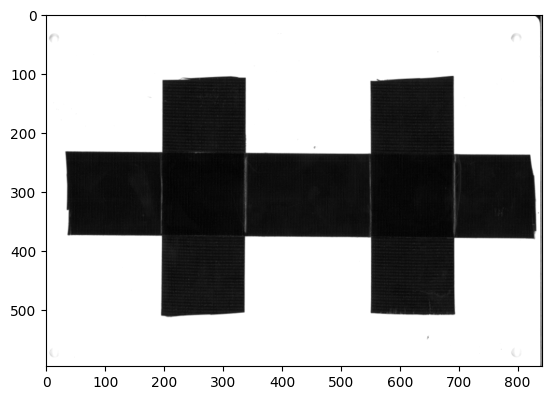

In [227]:
slate_img = cv2.cvtColor(np.frombuffer(buffer=pix.samples, dtype=np.uint8).reshape((pix.height, pix.width, 3)), cv2.COLOR_BGR2GRAY)

plt.imshow(slate_img, cmap="gray")

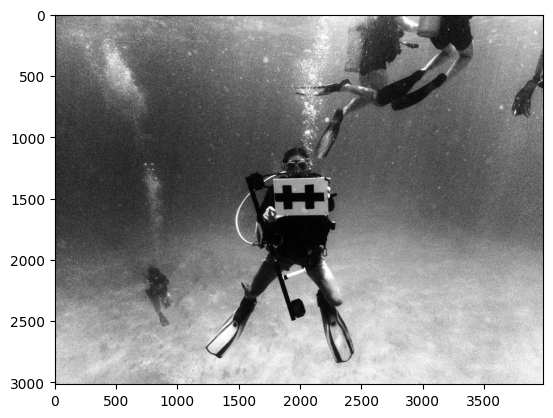

In [228]:
img = cv2.cvtColor(uint16_2_uint8(image_rectifier.rectify(raw_processor.load_and_process(img_path))), cv2.COLOR_BGR2GRAY)

plt.imshow(img, cmap="gray")

In [229]:
avg_pixel_intensity = cv2.mean(img)[0]

avg_pixel_intensity

124.91161967708048

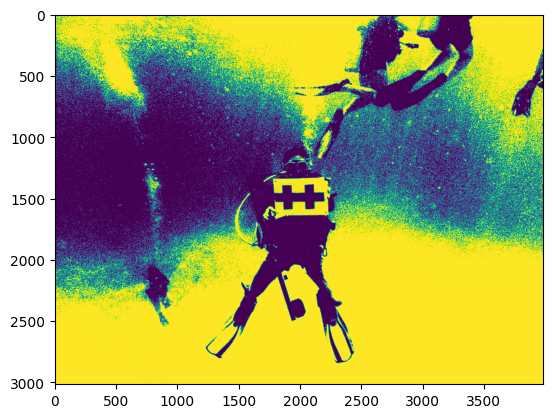

In [246]:
thresholded = cv2.inRange(img, 100, 255) 

plt.imshow(thresholded)

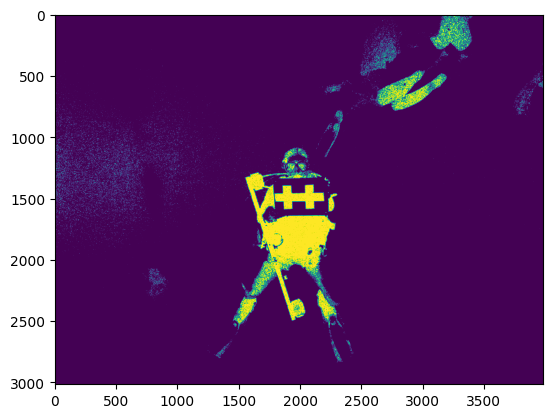

In [241]:
thresholded = cv2.inRange(img, avg_pixel_intensity*0.2, 255) 
thresholded = 255 - thresholded

plt.imshow(thresholded)

In [231]:
# ret, thresholded = cv2.threshold(img, 50, 255, cv2.THRESH_BINARY_INV)

# plt.imshow(thresholded)

In [232]:
# get the largest contour from the original slate pdf
ret2, slate_threshold = cv2.threshold(slate_img, 100, 255, cv2.THRESH_BINARY_INV)
kernel = np.ones((5,5),np.uint8)
opened = cv2.morphologyEx(slate_threshold, cv2.MORPH_OPEN, kernel)
slate_contours, slate_hierarchy = cv2.findContours(opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

max_area = 0
slate_contour = None
for c in slate_contours:
    area = cv2.contourArea(c)
    if area > max_area:
        max_area = area
        slate_contour = c

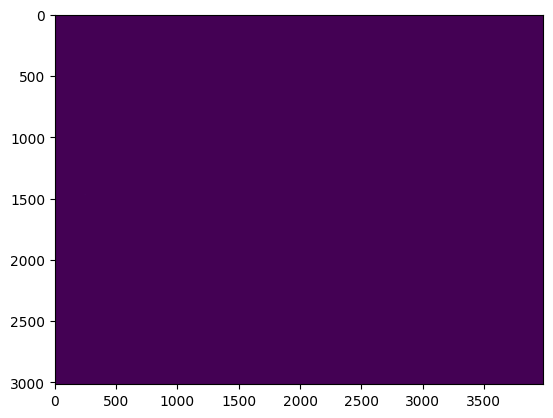

In [233]:
# get the matching contour in the calibration image
test_contours, hierarchy = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
min_score = np.inf
slate_in_image = None
for t in test_contours: 
    score = cv2.matchShapes(t, slate_contour, cv2.CONTOURS_MATCH_I2, 0.0)
    if score < min_score: 
        min_score = score
        slate_in_image = t

img_contour: np.ndarray = cv2.approxPolyDP(slate_in_image, 10, closed=True)
display = cv2.drawContours(np.zeros(img.shape), [img_contour], 0, 255, cv2.FILLED, 8)
plt.imshow(display)

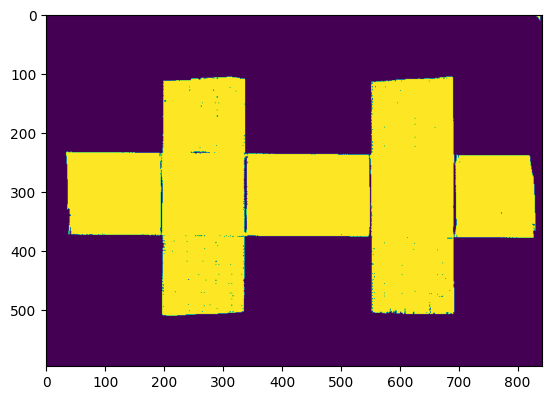

In [234]:
ret, pdf_threshold = cv2.threshold(slate_img, 50, 255, cv2.THRESH_BINARY_INV)
plt.imshow(pdf_threshold)

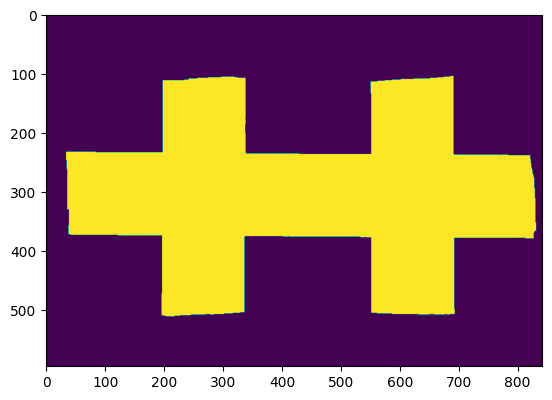

In [235]:
pdf_display = cv2.drawContours(np.zeros(pdf_threshold.shape), [slate_contour], 0, 255, cv2.FILLED, 8)
plt.imshow(pdf_display)

In [236]:
def error(img_contour: np.ndarray, slate_contour: np.ndarray):
    return scipy.spatial.distance.cdist(slate_contour.astype(float), img_contour.astype(float)).min(axis=1).mean() ** 2

def homo2contour(homogeneous_coords: np.ndarray):
    return np.round(homogeneous_coords[:, :2]).astype(int)

In [237]:
def calculate_transform(img_contour: np.ndarray, slate_contour: np.ndarray, angle: float):
    T = np.array([[cos(angle), -sin(angle), 0],
                  [sin(angle), cos(angle), 0],
                  [0, 0, 1]], dtype=float)
    
    slate_height, _, _ = slate_contour.shape
    slate_contour_homo = np.ones((slate_height, 3), dtype=float)
    slate_contour_homo[:, :2] = slate_contour.squeeze(1)

    transformed_slate_contour = (T @ slate_contour_homo.T).T

    img_radius = np.sqrt(cv2.contourArea(img_contour) / np.pi)
    slate_radius = np.sqrt(cv2.contourArea(homo2contour(transformed_slate_contour)) / np.pi)

    scale = img_radius / slate_radius

    T *= scale
    T[2, 2] = 1

    transformed_slate_contour = (T @ slate_contour_homo.T).T

    img_M = cv2.moments(img_contour)
    img_cx = int(img_M['m10']/img_M['m00'])
    img_cy = int(img_M['m01']/img_M['m00'])
    img_center = np.array([[img_cx], [img_cy]])

    slate_M = cv2.moments(homo2contour(transformed_slate_contour))
    slate_cx = int(slate_M['m10']/slate_M['m00'])
    slate_cy = int(slate_M['m01']/slate_M['m00'])
    slate_center = np.array([[slate_cx], [slate_cy]])

    T[:2, 2] = (img_center - slate_center).squeeze()

    return T

In [238]:
slate_height, _, _ = slate_contour.shape
slate_contour_homo = np.ones((slate_height, 3), dtype=float)
slate_contour_homo[:, :2] = slate_contour.squeeze(1)

In [239]:
_, _, img_angle = cv2.fitEllipse(img_contour)
_, _, slate_angle = cv2.fitEllipse(slate_contour)

angle_difference_one = (img_angle - slate_angle) * np.pi / 180.0

error: OpenCV(4.7.0) /io/opencv/modules/imgproc/src/shapedescr.cpp:360: error: (-201:Incorrect size of input array) There should be at least 5 points to fit the ellipse in function 'fitEllipseNoDirect'


In [ ]:
T_one = calculate_transform(img_contour, slate_contour, angle_difference_one)
T_two = calculate_transform(img_contour, slate_contour, np.pi + angle_difference_one)

In [ ]:
transformed_slate_contour_one = (T_one @ slate_contour_homo.T).T
transformed_slate_contour_two = (T_two @ slate_contour_homo.T).T

In [ ]:
error_one = error(img_contour.squeeze(1), homo2contour(transformed_slate_contour_one))
error_two = error(img_contour.squeeze(1), homo2contour(transformed_slate_contour_two))

error_one, error_two

(303.5532613403958, 382.8381280050287)

In [ ]:
transformed_slate_contour = transformed_slate_contour_one if error_one < error_two else transformed_slate_contour_two
T = T_one if error_one < error_two else T_two


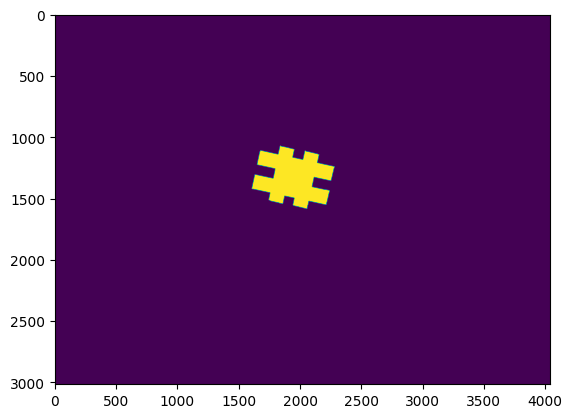

In [ ]:
pdf_display = cv2.drawContours(np.zeros(img.shape), [homo2contour(transformed_slate_contour)], 0, 255, cv2.FILLED, 8)
plt.imshow(pdf_display)

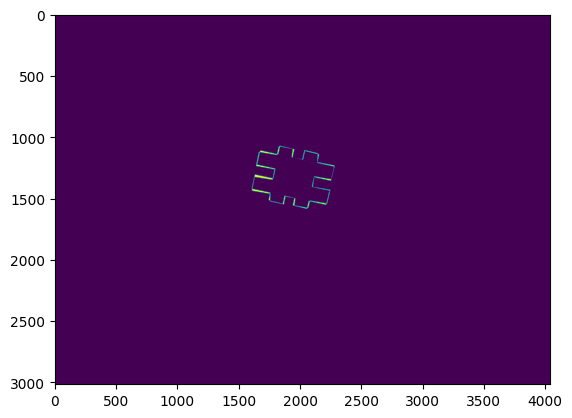

In [ ]:
plt.imshow(np.abs(pdf_display - display))

In [ ]:
img_corners = scipy.spatial.distance.cdist(img_contour.squeeze(1).astype(float), homo2contour(transformed_slate_contour).astype(float), 'euclidean').argmin(axis=1)

img_corners

array([ 28,  29,  32,  35,  36,  38,  41,  49,  56,  58,  60,  63,  71,
        80,  82,  92, 100, 107, 112, 126, 131, 134,   0,   4,  12,  14,
        21,  23])

In [ ]:
slate_coords = np.zeros((img_corners.shape[0], 3))
slate_coords[:, :2] = slate_contour[img_corners, 0, :]

slate_coords

array([[  0., 144.,   0.],
       [  0., 273.,   0.],
       [179., 285.,   0.],
       [178., 371.,   0.],
       [  0., 371.,   0.],
       [  9., 511.,   0.],
       [181., 512.,   0.],
       [199., 587.,   0.],
       [321., 588.,   0.],
       [322., 510.,   0.],
       [419., 512.,   0.],
       [424., 584.,   0.],
       [559., 583.,   0.],
       [560., 510.,   0.],
       [730., 483.,   0.],
       [734., 371.,   0.],
       [561., 371.,   0.],
       [561., 274.,   0.],
       [726., 261.,   0.],
       [729., 134.,   0.],
       [561., 133.,   0.],
       [547.,  51.,   0.],
       [422.,  45.,   0.],
       [420., 134.,   0.],
       [318., 133.,   0.],
       [299.,  54.,   0.],
       [178.,  49.,   0.],
       [177., 134.,   0.]])

In [ ]:
empty_dist_coeffs = np.zeros((5,))
ret, rvecs, tvecs = cv2.solvePnP(slate_coords, img_contour.squeeze(1).astype(float), calibration_matrix, empty_dist_coeffs)
rmat, _ = cv2.Rodrigues(rvecs)

tvecs, rmat

(array([[-330.15385119],
        [-513.11528418],
        [3239.9258756 ]]),
 array([[ 0.98182253, -0.18922115, -0.01482838],
        [ 0.18394208,  0.96786722, -0.17145946],
        [ 0.04679566,  0.1656152 ,  0.98507958]]))

In [ ]:
pixel_size = 0.0254 / pix.xres

In [ ]:
board_plane_points = ((rmat @ slate_coords.T + tvecs) * pixel_size).T

board_plane_points

array([[-0.09456253, -0.09888601,  0.86354033],
       [-0.10102089, -0.06585149,  0.86919298],
       [-0.05512214, -0.05406694,  0.87193507],
       [-0.05968748, -0.0320926 ,  0.87569113],
       [-0.10592723, -0.0407555 ,  0.87348724],
       [-0.11059834, -0.00446608,  0.87973334],
       [-0.06596729,  0.0041609 ,  0.88190675],
       [-0.06504622,  0.02424304,  0.88541604],
       [-0.03340387,  0.03043662,  0.88697039],
       [-0.02923905,  0.01051093,  0.88356488],
       [-0.00414111,  0.01574389,  0.88485351],
       [-0.0064469 ,  0.0344251 ,  0.88807039],
       [ 0.02867263,  0.0407392 ,  0.88969805],
       [ 0.03258714,  0.02209392,  0.88651165],
       [ 0.07810044,  0.02345328,  0.88743336],
       [ 0.08474679, -0.00503318,  0.88257516],
       [ 0.03980591, -0.01345275,  0.88043318],
       [ 0.04466219, -0.03829266,  0.87618274],
       [ 0.08817573, -0.0335915 ,  0.87765601],
       [ 0.09531327, -0.06596785,  0.87212814],
       [ 0.05172133, -0.07440015,  0.870

In [ ]:
normal_vec = np.cross(board_plane_points[1] - board_plane_points[0], board_plane_points[2] - board_plane_points[0])
normal_vec

array([ 2.39696359e-05,  2.77159115e-04, -1.59235180e-03])